# Analysis code

Python code used for <b>75 Years of Systematic Biology: Looking Back, Moving Forward</b>

Based on the shared ideas of Michael Landis and Michael Donoghue.

This notebook does the following:
- Cleans up and extracts relevant articles from *SZ*/*SB* dataset
- Embeds research articles using SPECTER
- Predicts topics using BERTopic
- Measures similarity among articles
- Measures citation rates for article clusters
- Measures numbers and lengths of article types
- Generates Figures 1-3 and Supp. Figures S1-5
- Also generates some fun visualizations that didn't go in the paper
- Saves topic modeling output to file
- Nourishes your love/hate relationship with AI

## Imports

In [1]:
# basics
import datetime
import time
import os
import re
import random
from copy import deepcopy

# processing
import pandas as pd
import numpy as np
import torch

# plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import plotly.graph_objects as go
from wordcloud import WordCloud

# machine learning stuff
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from scipy.cluster import hierarchy as sch
from scipy.stats import gaussian_kde
from scipy import stats
from umap import UMAP
from hdbscan import HDBSCAN

# BERT stuff
from transformers import AutoModel
from sentence_transformers import SentenceTransformer, util
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer, OnlineCountVectorizer
from bertopic.dimensionality import BaseDimensionalityReduction
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, ZeroShotClassification, PartOfSpeech


## Functions, global vars, etc.

In [2]:
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def similarity(vec1, vec2):
    return np.dot(vec1, vec2)

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.concatenate( [a[:(n-1)], ret[n - 1:] / n] )

def make_better_labels(topics_info, labels, df_counts, n=6):
    tmp         = topics_info[ topics_info['Name'].isin(labels) ]
    id          = tmp['Topic'].to_list()
    num_topics  = topics_info.shape[0] - 1   #  remove outlier topic
    count       = [ sum(df_counts[i].to_list()) for i in id ]
    lbl         = [ f'Topic {id[i]}, n={count[i]}: ' + ', '.join(x[:n]) for i,x in enumerate(tmp['Representation']) ]
    return lbl

# custom colors
my_colors = { 'orange':'#ffaa00',
              'red':'#ee6677',
              'blue':'#4477aa' }

## Prepare datasets

In [3]:
# FILESYSTEM

# base_dir     = "/Users/mlandis/projects/syst_biol_75/"
base_dir     = "./"
data_dir     = base_dir + "data/"
plot_dir     = base_dir + "plot/"
out_dir      = base_dir + "output/"
papers_fn    = data_dir + "systbiol_articles_enhanced_250717.xlsx"


In [4]:
# READ FULL DATASET

# get papers
df_orig = pd.read_excel(papers_fn)

# reverse order (oldest to youngest)
df_orig = df_orig.iloc[::-1]

# get statistics for original dataset
num_records_orig = df_orig.shape[0]
counts           = df_orig.groupby('PubYear').count()['DOI'].to_list()
years_unique     = np.unique( df_orig['PubYear'] )

# get all unique document types
# NB: curated document types were updated based on Syst Biol website HTML + manual corrections
df_orig['Document.Type.Curated'] = df_orig['Document.Type.Curated'].str.title()
uniq_doc_types = df_orig['Document.Type.Curated'].unique()

# find symposia document types (descriptions vary depending on symposium)
symp_types = [ x for x in uniq_doc_types if 'Symposium' in x ]
symp_types = [ x for x in symp_types if (x != 'Symposium Announcement' and x != 'Symposium Announcements')  ]

# define set of articles to compare (we focus on research articles)
# note: POVs and book reviews do not have abstracts
valid_types = ['Research Article',]
               # 'Point Of View',
               # 'Book Review',
               # 'Software For Systematics And Evolution',
               # 'Spotlight Article'
               # + symp_types


In [5]:
# FILTERING + NEW INPUT COLUMNS

# only retain records with valid curated document type
df = df_orig[ df_orig['Document.Type.Curated'].isin(valid_types) ].copy()

# text for each record represented by concatenation of abstract and title
col_name                         = 'Title.Abstract'
titles                           = df['Title'].astype(str)
abstracts                        = df['Abstract'].astype(str)
titles[ titles == 'nan' ]        = ''
abstracts[ abstracts == 'nan' ]  = ''

# '{title} [SEP] {abstract}' format should match representation used by SPECTER
df['Title.Abstract']             = titles + '.  '  + '[SEP]' + '   ' + abstracts
texts                            = df['Title.Abstract'].tolist()
years                            = df['PubYear'].to_numpy(dtype='int')
n_texts                          = len(texts)

In [6]:
# PROCESS ALTERNATIVE REPRESENTATIONS FOR TIMES

# alternative representations of time based on publication date
times_str = df['Publication.date'].tolist()
times = []
times_idx = []
for i in range(len(times_str)):

    # use PubYear if Publication.date info is absent
    if times_str[i] != times_str[i]:
        zz = pd.Timestamp(year=years[i], month=1, day=1)

    # extract day/month if available
    elif type(times_str[i]) == str:
        dd = [ int(x) for x in times_str[i].split('-') ]
        m = 1
        d = 1
        y = dd[0]
        if len(dd) > 1:
            m = dd[1]
        if len(dd) > 2:
            d = dd[2]
        zz = datetime.date(y,m,d)    

    # already correct format?
    else:    
        zz = times_str[i]
        
    times.append( year_fraction(zz) )
    times_idx.append( zz.toordinal() )

times_idx = np.array(times_idx, dtype='int')
times_idx = times_idx - min(times_idx)

# put new values back into dataframe
df['TimesFraction']      = times
df['AgesFraction']       = 2025 - df['TimesFraction']
df['CitationsPerYear']   = df['Google.Scholar.Times.cited'] / df['AgesFraction']


In [7]:
# Create null datasets for similarity through time

# Check to see if file exists
sd_filename = './data/paper_metadata_view_cite_read.json'
sd_found = os.path.isfile(sd_filename)
if not sd_found:
    # ERROR: The SciDocs dataset stored in './data/paper_metadata_view_cite_read.json'
    #        could not be found. It is large (~900MB) and not bundled with this repository.
    #        Visit https://github.com/allenai/scidocs to learn how to download the file.
    raise FileNotFoundError(f'{sd_filename} is missing.')
    
# read SciDocs json file as data frame
sd_info = pd.read_json(sd_filename)

# reformat data frame
sd_info = sd_info.transpose()
sd_info.dropna(subset=['year'], inplace=True)
sd_info.dropna(subset=['title'], inplace=True) 
sd_info.dropna(subset=['abstract'], inplace=True)
sd_info = sd_info[ sd_info['year'] >= 1952 ]

# sample 20 articles per year from years with 20+ articles
sd_num_articles = 20
sd_info = sd_info.groupby('year').filter(lambda x: len(x) >= sd_num_articles)
sd_info_subsample = sd_info.groupby('year').sample(n=sd_num_articles).reset_index(drop=True)

# save texts and years for sampled articles
sd_texts = sd_info_subsample['title'] + ' [SEP] ' + sd_info_subsample['abstract']
sd_years = sd_info_subsample['year']


In [8]:
# Create null dataset for topic clustering

# clean up and tokenize abstract sentences
abstract_toks = [ [s.strip() for s in re.split(r'[.!?]+ ', x) if s.strip()] for x in abstracts ]
abstract_toks = np.concatenate(abstract_toks)
abstract_toks = [ x + '.' for x in abstract_toks ]
abstract_toks = [ x for x in abstract_toks if len(x) > 10 ]
abstract_toks = np.array(abstract_toks)

# shuffle abstract sentences
np.random.shuffle(abstract_toks)

# construct null abstracts of shuffled sentences
k = 0
null_abstracts = ['']*len(abstracts)
for i in range(len(abstract_toks)):
    null_abstracts[k] += ' ' + abstract_toks[i]
    k += 1
    if k >= len(abstracts):
        k = 0
        
# build null texts
null_texts = titles + '.  '  + '[SEP]' + '   ' + null_abstracts
null_texts = null_texts.to_list()

# construct null data frame, with shuffled Title.Abstract field
df_null = df.copy()
df_null['Title.Abstract'] = null_texts


## Text embedding (pre-processing)

In [9]:
# GENERATE EMBEDDINGS

# set random seed for reproducibility
seed = 75
np.random.seed(seed)
torch.manual_seed(seed)

# generate initial embeddings
# link: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html
#model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')              # faster, generic
#model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')             # higher quality, generic
sentence_model = SentenceTransformer('sentence-transformers/allenai-specter')       # higher quality, scientific (best available)

# transform texts into embedded vector space
embeddings = sentence_model.encode(texts, show_progress_bar=True)

Batches:   0%|          | 0/80 [00:00<?, ?it/s]

In [ ]:
# generate embeddings for Scidocs dataset
sd_sentence_model = SentenceTransformer('sentence-transformers/allenai-specter')       # higher quality, scientific (best available)
sd_embeddings = sentence_model.encode(sd_texts, show_progress_bar=True)

In [ ]:
# generate embeddings for null SZ/SB dataset
null_sentence_model = SentenceTransformer('sentence-transformers/allenai-specter')       # higher quality, scientific (best available)
null_embeddings = sentence_model.encode(null_texts, show_progress_bar=True)

## Similarities (processing & visualization)

In [10]:
# PROCESS SIMILARITIES


def pairwise_similarities(embeddings, years):
    # compute similarities between all pairs of articles
    n_texts = len(embeddings)
    similarities = np.zeros([n_texts,n_texts])
    for i in range(0,n_texts):
        for j in range(i,n_texts):
            # similarities are symmetric
            similarities[i][j] = cosine_similarity(embeddings[i], embeddings[j])
            similarities[j][i] = similarities[i][j]
    
    # build matrix of mean similarity across year-bins
    yy = np.unique(years)
    n_years = len(yy)
    mean_sim = np.zeros((n_years,n_years))
    for i in range(n_years):
        ii = np.where(years == yy[i])
        for j in range(n_years):
            jj = np.where(years == yy[j])
            mm = np.mean( similarities[ ii[0][0]:ii[0][-1], jj[0][0]:jj[0][-1] ] )
            mean_sim[i,j] = mm

    return mean_sim


In [11]:
# PROCESS SIMILARITIES

# compute similarities between all pairs of articles 
similarities = np.zeros([n_texts,n_texts])
for i in range(0,n_texts):
    for j in range(i,n_texts):
        # similarities are symmetric
        similarities[i][j] = cosine_similarity(embeddings[i], embeddings[j])
        similarities[j][i] = similarities[i][j]

# build matrix of mean similarity across year-bins
yy = np.unique(years)
n_years = len(yy)
mean_sim = np.zeros((n_years,n_years))
for i in range(n_years):
    ii = np.where(years == yy[i])
    for j in range(n_years):
        jj = np.where(years == yy[j])
        mm = np.mean( similarities[ ii[0][0]:ii[0][-1], jj[0][0]:jj[0][-1] ] )
        mean_sim[i,j] = mm

mm2 = pairwise_similarities(embeddings, years)

In [ ]:
# FIGURE 1: HEATMAP OF MEAN-SIMILARITIES BY YEAR

# colors
n_bins = 5
hex_colors = ['#5d75c9', '#8da5da', '#b3c5e6', '#d5def0', '#eef2fb'][::-1]
cmap = matplotlib.colors.ListedColormap(hex_colors)

# heatmap
hm = plt.imshow(mean_sim, cmap=cmap, interpolation='nearest')

# axes
plt.gca().invert_yaxis()
plt.xlabel("Journal year")
plt.ylabel("Journal year")
xy_ticks = list(range(n_years))[::10]
xy_lbls = [str(x) for x in yy][::10]
plt.xticks(xy_ticks, xy_lbls)
plt.yticks(xy_ticks, xy_lbls)

# legend
cbar = plt.colorbar(hm)
cbar.set_label('mean similarity')

# save
plt.savefig(plot_dir + 'fig_1_heatmap_similarity.pdf')
plt.show()
plt.clf()

In [ ]:
# TESTS

def matrix_permute_rowcol(m):
    m_ = m.copy()
    row_perm = np.random.permutation(m_.shape[0])
    m_[:,:] = m[row_perm][:, row_perm]
    return m_

# get null years
sd_yy = np.unique(sd_years)

# make null similarity matrices
mean_sim_shuffle_year = matrix_permute_rowcol(mean_sim)
sd_mean_sim = pairwise_similarities(sd_embeddings, sd_years)
sd_mean_sim_shuffle_year = matrix_permute_rowcol(sd_mean_sim)

# adjust placement of scidocs matrices
start_idx = np.where(yy == min(sd_yy))[0][0]
end_idx = np.where(yy == max(sd_yy))[0][0]
sd_mean_sim_adj = np.zeros((len(yy),len(yy)))
sd_mean_sim_adj[:,:] = -1.0
sd_mean_sim_adj[start_idx:end_idx, start_idx:end_idx] = sd_mean_sim
sd_mean_sim_shuffle_year_adj = np.zeros((len(yy),len(yy)))
sd_mean_sim_shuffle_year_adj[:,:] = -1.0
sd_mean_sim_shuffle_year_adj[start_idx:end_idx, start_idx:end_idx] = sd_mean_sim_shuffle_year
                    

In [ ]:
# FIGURE S1: all heatmaps

# colors
n_bins = 10
#hex_colors = ['#5d75c9', '#8da5da', '#b3c5e6', '#d5def0', '#eef2fb'][::-1]
hex_colors = ['#5d75c9', '#758dd2', '#8da5da', '#a0b5e0', '#b3c5e6', '#c4d2eb', '#d5def0', '#e2e8f6', '#eef2fb', '#f7f9fd'][::-1]
cmap = matplotlib.colors.ListedColormap(hex_colors)
cmap.set_bad(color='white')
cmap.set_under(color='white')

#sim_list = [ mean_sim, mean_sim_shuffle_year, sd_mean_sim, sd_mean_sim_shuffle_year ]
#year_list = [ yy, yy, sd_yy, sd_yy ]

sim_list = [ mean_sim, mean_sim_shuffle_year, sd_mean_sim_adj, sd_mean_sim_shuffle_year_adj ]
year_list = [ yy, yy, yy, yy ]
title_list = [ 'SZ/SB (D1)', 'SZ/SB, year-shuffled (D2)', 'SciDocs (D3)', 'SciDocs, year-shuffled (D4)' ]

vmin = np.min([ np.min(x[x > 0.]) for x in sim_list ])
vmax = np.max([ np.max(x) for x in sim_list ])

#print(min_val, max_val)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
fig.subplots_adjust(right=0.8)


k = 0
for i in range(2):
    for j in range(2):
        hm = ax[i,j].imshow(sim_list[k], cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)      
        ax[i,j].invert_yaxis()
        ax[i,j].set_xlabel("Journal year")
        ax[i,j].set_ylabel("Journal year")
        ax[i,j].title.set_text(title_list[k])
        xy_ticks = list(range(len(year_list[k])))[::10]
        xy_lbls = [str(x) for x in year_list[k]][::10]
        print(xy_ticks)
        print(xy_lbls)
        ax[i,j].set_xticks(xy_ticks, xy_lbls)
        ax[i,j].set_yticks(xy_ticks, xy_lbls)
        k += 1

# for i, a in enumerate(ax.flat):
#     a.text(-0.1, 1.1, '('+'abcd'[i]+')', transform=a.transAxes,
#             fontsize=16, va='top')

# legend
#cbar = plt.colorbar(hm)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.6])
plt.colorbar(hm, cax=cbar_ax, label='mean similarity')
#cbar.set_label('mean similarity')
#plt.show()
plt.subplots_adjust(hspace=0.0, wspace=0.3)
plt.savefig(plot_dir + 'fig_S1_heatmap_similarity.pdf')

# if False:
#     # heatmap
#     #hm = plt.imshow(mean_sim, cmap=cmap, interpolation='nearest')
#     #hm = plt.imshow(mean_sim_shuffle_year, cmap=cmap, interpolation='nearest')
#     #hm = plt.imshow(sd_mean_sim, cmap=cmap, interpolation='nearest')
#     hm = plt.imshow(sd_mean_sim_shuffle_year, cmap=cmap, interpolation='nearest')
    
#     # axes
#     plt.gca().invert_yaxis()
#     plt.xlabel("Journal year")
#     plt.ylabel("Journal year")
#     xy_ticks = list(range(len(sd_yy)))[::10]
#     xy_lbls = [str(x) for x in sd_yy][::10]
#     plt.xticks(xy_ticks, xy_lbls)
#     plt.yticks(xy_ticks, xy_lbls)
    
#     # legend
#     cbar = plt.colorbar(hm)
#     cbar.set_label('mean similarity')
    
#     # save
#     plt.savefig(plot_dir + 'fig_1_heatmap_similarity.pdf')
#     plt.show()
#     plt.clf()

In [ ]:
# FIGURE S2: similarity through time

colors = [ 'darkblue','lightblue','darkred','pink' ]
zorder = [ 10,1,10,1 ]
lines = []
for k in range(len(sim_list)):
    xval = np.diag(sim_list[k]).copy()
    for i in range(len(xval)):
        if xval[i] < 0.0:
            xval[i] = np.nan
    #xval = [ x for x in xval if x >= 0 else np.nan ]
    p, = plt.plot( year_list[k], xval, linewidth=1, c=colors[k], zorder=zorder[k] )
    lines.append(p)

#line1, = plt.plot(yy,np.diag(mean_sim), linewidth=2, zorder=10)
#line2, = plt.plot(yy,np.diag(mean_sim_block_rep[0,:,:]), linewidth=1)

#line4, = plt.plot(yy_null,np.diag(mean_sim_null),linewidth=1)
#line5, = plt.plot(yy_null,np.diag(mean_sim_block_null),linewidth=1)

#lines = [ line1, line2, line4, line5 ]
labels = ['SZ/SB (D1)', 'SZ/SB, year-shuffled (D2)', 'SciDocs (D3)', 'SciDocs, year-shuffled (D4)']


plt.legend(lines,
           labels,
           fontsize=8,
           loc='upper right')

plt.xlabel('Publication year')
plt.ylabel('Mean similarity')


plt.ylim(0.5,1)
plt.savefig(plot_dir + 'fig_S2_lineplot_similarity.pdf')


In [ ]:
# FIGURE S3: step sizes between adjacent years
# ... let's skip this one ...

dx1 = np.diff( np.diag(mean_sim) )
dx2 = []
for i in range(n_rep):
    dx2.append( np.diag(mean_sim_block_rep[i,:,:]) )
dx2 = np.array(dx2)
dx2 = dx2.flatten()
dx2 = np.diff( dx2 )

dx1 = dx1 / np.std(dx1)
dx2 = dx2 / np.std(dx2)

window_size = 10
sx1 = np.convolve(dx1, np.ones(window_size), mode='valid')
sx2 = np.convolve(dx2, np.ones(window_size), mode='valid')


x_multi = [sx1, sx2]
plt.hist(x_multi, 15, histtype='bar', density=True)
#ax3.set_title('different sample sizes')

## Topic modeling (processing)

In [12]:
# GENERATE HIERARCHICAL TOPICS

# BERTopic workflow is:

# 1. Embedding: put text into 784-dim numerical space (computed above; slow)
# 2. Dimension reduction: reduce embedding to k dimensions
# 3. Clustering: infer unnamed topic clusters
# 4. Vectorize: converts text into bag-of-words (vector) representation
# 5. c-TF-IDF (topic-naming): extract the most important words for each topic
# 6. Representation: refines topic keywords to make them more interpretable

# Steps 1-3 determine the number and composition of topics, whereas steps 4-6
# determine the keywords associated with each topic-cluster.

# RNG
seed = 75
np.random.seed(seed)
torch.manual_seed(seed)

# good settings
n_neighbors        = 20      # Dimension reduction
n_components       = 5       # Dimension reduction
min_dist           = 0.0     # Dimension reduction
min_cluster_size   = 15      # Clustering
min_samples        = 3       # Clustering
seed_multiplier    = 2.0     # c-TF-IDF
diversity          = 0.5     # Representation
top_n_words_rep    = 10      # Representation
top_n_words_full   = 30      # BERTopic
n_gram_range       = (1,3)   # BERTopic
min_topic_size     = 15      # BERTopic
nr_topics          = 40      # BERTopic


## 1. Embedding model:
## - convert documents into k-dimensional vector space
# ... pre-computed above!


## 2. Dimension reduction model:
## - project 784-dimensional vectors onto fewer dimensions
# UMAP model pre-process reduce dimensionality of data down to n_components
# umap_model = empty_dimensionality_model = BaseDimensionalityReduction()
# umap_model = UMAP(n_neighbors=10, n_components=20, min_dist=0.0, metric='cosine', random_state=seed)
umap_model = UMAP(n_neighbors=n_neighbors,
                  n_components=n_components,
                  min_dist=min_dist,
                  metric='euclidean',
                  random_state=seed)


## 3. Clustering model:
## - find dense clusters of documents in vector-space
hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size,
                        min_samples=min_samples,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True)


## 4. Vectorizer model: converts raw text into sparse matrix of word counts
## - c-TF-IDF uses this matrix to choose topic names
# vectorizer_model = OnlineCountVectorizer(stop_words="english", decay=0.1)
vectorizer_model =  CountVectorizer(stop_words="english")


## 5. c-TF-IDF model:
## - select which topics are most representative of papers
# seed words
# link: https://maartengr.github.io/BERTopic/getting_started/seed_words/seed_words.html
seed_topic_list = ['phylogenetic','phylogeny','lineage',
                   'taxonomy','taxon','species','delimitation','classification','nomenclature',
                   'cladistic','clade','synapomorphy','homoplasy',
                   'phenetic', 'numerical',
                   'homology','ortholog','paralog',
                   'divergence','dating','calibration','age','deep time',
                   'macroevolution','microevolution',
                   'topology','branch length','branch','mrca','treespace','tree distance',
                   'simulation','estimation','inference','estimate','method','software',
                   'likelihood','parsimony','bayesian','posterior','prior',
                   'ancestral','rate','state','process','model','evolution',
                   'monocot','dicot','plant','angiosperm','gymnosperm','fungi','woody','herbaceous','flower',
                   'animal','mammal','bird','reptile','fish','amphibian','invertebrate','insect','arachnid','bivalve','mollusk','worm',
                   'bacteria','virus','microbe','prokaryote','archaea','protist','yeast','mushroom',
                   'nucleotide','genomic','genetic','adaptation','dna','rna','sequence',
                   'mtdna','mitochondria','cpdna','chloroplast','plastid','electrophoretic','microsatellite',
                   'epidemiology','infectious','outbreak','disease','phylodynamic',
                   'phenotype','morphology','character','trait','biogeography','ecology','environment','niche',
                   'speciation','diversification','radiation','fossilization','fossil','paleontology','paleobiology',
                   'parasite','host','mutualism','mimicry','pollinator','symbiont','coevolution','cophylogenetic','codiversification',
                   'hybridization','introgression','polyploidy','diploid','duplication','chromosome',
                   'coalescent','substitution','concatenation','species tree','gene tree','network']

# rebalance term frequency-inverse document frequency, reweight terms, import seed words
# link: https://maartengr.github.io/BERTopic/getting_started/ctfidf/ctfidf.html
ctfidf_model = ClassTfidfTransformer(seed_multiplier=seed_multiplier,
                                     seed_words=seed_topic_list,
                                     reduce_frequent_words=True,
                                     bm25_weighting=True)



## 6. Representation model:
## - adjusts keywords proposed by c-TF-IDF to be more interpretable/diverse
## - MMR: increases diversity of keywords

mmr = MaximalMarginalRelevance(diversity=diversity,
                               top_n_words=top_n_words_rep)
## - POS: uses grammatical rules to combine keywords
pos_patterns = [
    [{'POS': 'ADJ'}, {'POS': 'NOUN'}],
    [{'POS': 'NOUN'}],
    [{'POS': 'ADJ'}]
]
pos = PartOfSpeech("en_core_web_lg",
                   top_n_words=top_n_words_rep,
                   pos_patterns=pos_patterns)

# setup vector of rep. models
representation_model = [ mmr, pos ]


## BERTopic analysis

# construct topic model
topic_model = BERTopic(
                       embedding_model=sentence_model,
                       representation_model=representation_model,
                       ctfidf_model=ctfidf_model,
                       umap_model=umap_model,
                       vectorizer_model=vectorizer_model,
                       hdbscan_model=hdbscan_model,
                       verbose=True,
                       top_n_words=top_n_words_full,
                       n_gram_range=n_gram_range,
                       min_topic_size=min_topic_size,
                       nr_topics=nr_topics,
                       calculate_probabilities=True)


# get topics (and probs) for all texts
topics, probs = topic_model.fit_transform(texts, embeddings)

# construct hierarchically clustered embeddings
print("Get hierarchical topics")
hierarchical_topics = topic_model.hierarchical_topics(texts)

# approximate topic probabilities per token per document (takes time)
print("Get topic probabilities per token per document")
topic_distr, topic_token_distr = topic_model.approximate_distribution(texts, calculate_tokens=True, window=8)


2025-11-03 13:00:01,868 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-03 13:00:16,539 - BERTopic - Dimensionality - Completed ✓
2025-11-03 13:00:16,540 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-03 13:00:16,790 - BERTopic - Cluster - Completed ✓
2025-11-03 13:00:16,790 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-03 13:00:17,199 - BERTopic - Representation - Completed ✓
2025-11-03 13:00:17,202 - BERTopic - Topic reduction - Reducing number of topics
2025-11-03 13:00:17,212 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-03 13:00:44,264 - BERTopic - Representation - Completed ✓
2025-11-03 13:00:44,266 - BERTopic - Topic reduction - Reduced number of topics from 43 to 40


Get hierarchical topics


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:23<00:00,  1.60it/s]


Get topic probabilities per token per document


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.90s/it]


In [13]:
# POSTPROCESS TOPIC ASSIGNMENTS

probability_threshold  = 0.01
new_topics             = [np.argmax(prob) if max(prob) >= probability_threshold else -1 for prob in probs]
topics_bak             = topics
topics                 = new_topics
num_topics_old         = len(np.unique(topics_bak))
num_topics             = len(np.unique(topics))
num_assign_old         = sum(x != -1 for x in topics_bak)
num_assign_new         = sum(x != -1 for x in new_topics)

print('num_texts           =', len(topics))
print('num_topics_old      =', num_topics_old)
print('num_topics_new      =', num_topics)
print('num_assign_old      =', num_assign_old)
print('num_assign_new      =', num_assign_new)
print('num_unassigned_old  =', len(topics) - num_assign_old)


num_texts           = 2531
num_topics_old      = 40
num_topics_new      = 39
num_assign_old      = 1799
num_assign_new      = 2531
num_unassigned_old  = 732


In [14]:
# UPDATE DATAFRAMES WITH POSTPROCESSED TOPICS

# generate list of texts, updated topics, and topic probabilities
text_topics                         = topic_model.get_document_info(texts)
text_topics.insert(0, 'Research_Article_ID', range(text_topics.shape[0]))
text_topics.insert(3, 'BestTopic', new_topics)
prob_col_names                      = [ f'Prob_Topic_{i}' for i in range(num_topics) ]#
text_topics[prob_col_names]         = probs

# generate list of topics and updated topic counts
topics_info                         = topic_model.get_topic_info()
new_topic_counts                    = dict.fromkeys(topics_info['Topic'], 0)
for id in new_topics:
    new_topic_counts[id]            = new_topic_counts[id] + 1
    
topics_info.insert(2, 'BestTopicCount', new_topic_counts.values())
topics_info.insert(3, 'BestTopicCountRatioIncrease', topics_info['BestTopicCount'] / topics_info['Count'])

# update main datafarme with updated topics
df['TopicNumber']                   = topics
df['TopicLabel']                    = [ topics_info['Name'][x+1] for x in topics ]

# save to file
topics_info.to_csv(out_dir + 'topics_info.csv')
text_topics.to_csv(out_dir + 'texts_info.csv')


In [15]:
# FIND DEEP CLUSTERS

# distance threshold:
# - larger distance/depth means fewer, larger clusters
# - smaller distance/depth means more, smaller clusters
clust_dist = 1.1    

# get all cluster-nodes with distance > dist
cluster_nodes = hierarchical_topics[ hierarchical_topics['Distance'] > clust_dist ]
cluster_id = cluster_nodes['Child_Left_ID'].to_list() + cluster_nodes['Child_Right_ID'].to_list()
cluster_id = [ x for x in cluster_id if x not in cluster_nodes['Parent_ID'].to_list() ]

# info about deep clusters
# print(cluster_nodes)
# print(cluster_id)

# store topics for deep-cluster nodes
deep_topic_id = {}
df['deep_topic_id'] = 0
for i in cluster_id:
    deep_topic_id[i] = hierarchical_topics[ hierarchical_topics['Parent_ID']==i ].iloc[0]['Topics']
    match_idx = df['TopicNumber'].isin( deep_topic_id[i] )
    df['deep_topic_id'][match_idx] = i

# verify no topics are lost
num_topics_deep = sum( [ len(x) for x in deep_topic_id.values()  ] )
num_topics_flat = len(np.unique(topics))
if num_topics_deep != num_topics_flat:
    print(f'num_topics_deep = {num_topics_deep}')
    print(f'num_topics_flat = {num_topics_flat}')

# make dictionary of topics-to-clusters (hard-coded for now)
topics_to_clusters = np.zeros(num_topics_deep, dtype='int')
deep2int = {'70':1, '73':2, '74':0}
for k,v in deep_topic_id.items():
    for i in v:
        topics_to_clusters[i] = deep2int[k]

# get numbers of papers per topic per year
df_ttt = pd.DataFrame( {'year':years, 'topic':new_topics} )
df_counts = df_ttt.groupby(['topic','year']).size()

In [16]:
# minimum topic probability for article to be considered
th1 = 0.05

# threshhold for identifying multi-topic papers
# minimum percent of support that second-best topic is relative to first-best topic
th2 = 0.5

# examples:
#   - multitopic:     topic-1 is 0.3 and topic-2 is 0.2  =>  (0.5*0.3) < 0.2  => multi-topic
#   - not multitopic: topic-1 is 0.3 and topic-2 is 0.1  =>  (0.5*0.3) > 0.1  => single-topic
#   - not candidate:  topic-1 is 0.3 and topic-2 is 0.01 =>  th2 never used   => single-topic

my_topics = []
num_mult = 0
num_mismatch = 0
# for each article in data frame
for i in range(df.shape[0]):
    # find all topics with support above th1
    my_topics = np.where(probs[i] > th1)[0]
    if len(my_topics) > 1:
        num_mult += 1
        # find putative multitopic articles
        sort_idx = np.argsort( probs[i,:] )[::-1]
        is_close = (th2*probs[i,sort_idx[0]] < probs[i,sort_idx[1]])
        if is_close:
            # get clusters of best two topics
            my_topics = sort_idx[0:2]
            my_clusters = np.unique( topics_to_clusters[my_topics] )
            # count number of multi-topic articles from 2+ clusters
            if len(my_clusters) > 1:
                num_mismatch += 1

print('number of total papers           =', df.shape[0])
print('number of single-topic papers    =', df.shape[0] - num_mult)
print('number of multi-topic papers     =', num_mult)
print('number of single-cluster papers  =', num_mult-num_mismatch)
print('number of multi-cluster papers   =', num_mismatch)
print('percent of single-topic papers   =', (df.shape[0] - num_mult)/df.shape[0])
print('percent of multi-topic papers    =', num_mult/df.shape[0])
print('percent of single-cluster papers =', (num_mult-num_mismatch)/df.shape[0])
print('percent of multi-cluster papers  =', num_mismatch/df.shape[0])

number of total papers           = 2531
number of single-topic papers    = 1566
number of multi-topic papers     = 965
number of single-cluster papers  = 885
number of multi-cluster papers   = 80
percent of single-topic papers   = 0.6187277755827736
percent of multi-topic papers    = 0.3812722244172264
percent of single-cluster papers = 0.3496641643619123
percent of multi-cluster papers  = 0.03160806005531411


## Topic modeling (visualizations)

Plots are generated in a different order than how they appear in the paper, since they need to share information in particular ways (e.g. colors of topics, designation of clusters, etc.)

In [ ]:
fig = topic_model.visualize_hierarchy()
fig

In [ ]:
# FIGURE S2: PLOT TOPIC TREE & MAIN CLUSTERS

#fig = topic_model.visualize_hierarchy(hierarchical_topics, color_threshold=clust_dist, title='')
fig = topic_model.visualize_hierarchy(color_threshold=clust_dist, title='')

# customize figure
fig['layout']['title']                 = None
fig['layout']['xaxis']['automargin']   = True
fig['layout']['yaxis']['automargin']   = True
fig['layout']['yaxis']['side']         = 'right'
fig['layout']['paper_bgcolor']         = 'rgba(0,0,0,0)'
fig['layout']['plot_bgcolor']          = 'rgba(0,0,0,0)'
fig['layout']['xaxis']['showline']     = False
fig['layout']['xaxis']['ticks']        = 'outside'
fig['layout']['xaxis']['side']         = 'bottom' 
fig['layout']['xaxis']['mirror']       = False
fig['layout']['yaxis']['showline']     = False
fig['layout']['yaxis']['ticks']        = ''

# compute range of data
all_x = []
all_y = []
for trace in fig['data']:
    if 'x' in trace and trace['x'] is not None:
        all_x.extend(trace['x'])
    if 'y' in trace and trace['y'] is not None:
        all_y.extend(trace['y'])

# manually reverse axes against data range
# ... did this instead of auto reverse because of padding issues
def make_rev_axis(z, padding=0.01):
    zmin = min(z)
    zmax = max(z)
    zpad = padding * (zmax - zmin)
    return [zmax + zpad, zmin - zpad]

fig['layout']['xaxis']['range'] = make_rev_axis(all_x)
fig['layout']['yaxis']['range'] = make_rev_axis(all_y)

# update colors
for i in range(len(fig['data'])):
    if fig['data'][i]['marker']['color'] == 'rgb(61,153,112)':
        fig['data'][i]['line']['color'] = my_colors['blue']
    elif fig['data'][i]['marker']['color'] == 'rgb(255,65,54)':
        fig['data'][i]['line']['color'] = my_colors['red']
    elif fig['data'][i]['marker']['color'] == 'rgb(35,205,205)':
        fig['data'][i]['line']['color'] = my_colors['orange']
    elif fig['data'][i]['marker']['color'] == 'rgb(0,116,217)':
        fig['data'][i]['line']['color'] = 'black'

# save figure
fig.write_image(plot_dir + "fig_S4_topic_tree.pdf", format="pdf", height=800, width=800)  # requires kaleido
fig

In [ ]:
# FIGURE 2: PLOT TOPICS THROUGH TIME BY CLUSTER

n_cluster = len(deep_topic_id)
if n_cluster == 1:
    n_cluster = 2

titles = {}
for i in range(n_cluster):
    titles[i] = f'Cluster {i+1} research articles'
    
# figure
fig, ax = plt.subplots( nrows=n_cluster, ncols=2, width_ratios=[0.7, 1])
fig.set_size_inches(15, 5*n_cluster)
fig.tight_layout(pad=4.0)

# display
colormap1 = mpl.colormaps['tab20b'] #, len(np.unique(ttt_right['Topic'])))
colormap2 = mpl.colormaps['tab20c'] #, len(np.unique(ttt_right['Topic'])))
colors = np.vstack( [colormap1(range(20)), colormap2(range(20))] )
color_idx = 0
font_size = 10

# get vector of colors for each topic id
color_id_vec = [None] * num_topics

# get data
df_count_times = np.unique( [ x[1] for x in df_counts.index ] )
for i,(k,v) in enumerate(reversed(deep_topic_id.items())):
    y_val = {}
    df_count_id = np.unique( [ x[0] for x in df_counts.index ] )
    ii = 0

    for id in df_count_id:
        df_id = df_counts[id,:]
        # skip outlier-cluster
        if id == -1:
            continue
        # skip any topic ID not in the cluster
        if id not in v:
            continue

        # initialize each topic for zero papers each year
        y_dict = {}
        for t in df_count_times:
            y_dict[t] = 0.0

        # update number of papers for recorded years
        for j,ct in enumerate(df_id):
            year = float(df_id.index[j])
            y_dict[ year ] = ct

        # update y_val with papers per year per topic 
        kk = topics_info['Name'][id+1]
        yyy = moving_average( list(y_dict.values()), 4)
        y_val[kk] = np.array(yyy, dtype=float)

        
        #color_id_dict[id] = colors[color_idx:][ii]
        ii += 1

    
    ax[i,0].stackplot(df_count_times, list(y_val.values())[::-1], labels=y_val.keys(), colors=colors[color_idx:])

    # add color for topic id
    for j,id in enumerate(reversed(v)):
        color_id_vec[id] = colors[color_idx:][j]
    
    color_idx = color_idx + len(v)
    ax[i,0].set_ylim([0,40])
    handles, labels = ax[i,0].get_legend_handles_labels()

    better_labels = make_better_labels(topics_info, labels, df_counts, 7)
    
    ax[i,0].legend(handles[::-1], better_labels, loc='upper left', bbox_to_anchor=(1.04, 1), fontsize=font_size)
    ax[i,0].set_title(titles[i])
    ax[i,0].set_xlabel('Year')
    ax[i,0].set_ylabel('Num. articles')
    ax[i,1].axis('off')

    print(f'Cluster {i+1} size = ', np.sum(np.array(list(y_val.values()))), f'\tnum_topics = {num_topics}')

# convert color_id to color_vec
# used for figures S1 and S3!
color_id = np.vstack(color_id_vec)

# save figure
fig.savefig(plot_dir + 'fig_2_topic_thru_time_clusters.pdf')

In [ ]:
# FIGURE S3: PLOT TOPICS THROUGH TIME FOR ALL ARTICLES

# figure
fig, ax = plt.subplots( nrows=1, ncols=2, width_ratios=[3, 1])
fig.set_size_inches(14,8)
fig.tight_layout(pad=4.0)

# display
colormap1 = mpl.colormaps['tab20b']
colormap2 = mpl.colormaps['tab20c']
colors = np.vstack( [colormap1(range(20)), colormap2(range(20))] )
color_idx = 0
font_size = 7

# get data
df_count_times = np.unique( [ x[1] for x in df_counts.index ] )

i = 0
y_val = {}
df_count_id = np.unique( [ x[0] for x in df_counts.index ] )
for id in df_count_id:
    df_id = df_counts[id,:]

    # skip outlier-cluster
    if id == -1:
        continue

    # initialize each topic for zero papers each year
    y_dict = {}
    for t in df_count_times:
        y_dict[t] = 0.0

    # update number of papers for recorded years
    for j,ct in enumerate(df_id):
        year = float(df_id.index[j])
        y_dict[ year ] = ct

    # update y_val with papers per year per topic 
    kk = topics_info['Name'][id+1]
    yyy = moving_average( list(y_dict.values()), 4)
    y_val[kk] = np.array(yyy, dtype=float)

num_topics = len(list(y_val.keys()))

ax[0].stackplot(df_count_times, list(y_val.values()), labels=y_val.keys(), colors=color_id[:])
color_idx = color_idx + num_topics
ax[0].set_ylim([0,65])
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::], labels[::], loc='upper center',
             bbox_to_anchor=(0.5, -0.075), frameon=False, fontsize=font_size, ncol=3)

ax[0].set_title('All research articles')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Num. articles')
ax[1].axis('off')

print(f'Cluster {i} size = ', np.sum(np.array(list(y_val.values()))), f'\tnum_topics = {num_topics}')

# save figure
fig.savefig(plot_dir + 'fig_S5_topic_thru_time_all.pdf',bbox_inches='tight')

In [ ]:
# FIGURE S1: PLOT TOPICS ON 2D UMAP SPACE

reduced_embeddings_2d = UMAP(n_neighbors=20, n_components=2, metric='euclidean', min_dist=0.0).fit_transform(embeddings)

better_labels = make_better_labels(topics_info, topics_info['Name'].iloc[1:], df_counts, n=7)

fig, ax = plt.subplots(figsize=(17,13))

# topic_colors = color_id[ topics,: ]

# plot articles
for id in range(num_topics):
    id_idx = np.where( np.array(topics) == id)[0]
    x = reduced_embeddings_2d[id_idx,0]
    y = reduced_embeddings_2d[id_idx,1]
    ax.scatter(x=x, y=y, c=color_id[id,:], s=16, marker='o', label=better_labels[id], alpha=1)

# plot topic identifiers
for id in range(num_topics):    
    id_idx = np.where( np.array(topics) == id)[0]
    x = reduced_embeddings_2d[id_idx,0]
    y = reduced_embeddings_2d[id_idx,1]
    mean_x = np.median(x)
    mean_y = np.median(y)
    ax.scatter(x=mean_x, y=mean_y,
               facecolor='white', edgecolor=color_id[id,:],
               s=250, linewidths=2.0, marker='o', zorder=1e3+20*id+0)
    ax.annotate(str(id), (mean_x, mean_y),
            xytext=(0, 0), color='black',
            textcoords='offset points',
            ha='center', va='center', fontsize=10, zorder=1e3+20*id+1)

# plot legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::], labels[::], loc='upper center',
          bbox_to_anchor=(0.5, -0.05), frameon=False, fontsize=8.5, markerscale=2, ncol=2)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)


plt.savefig(plot_dir + 'fig_S3_topics_flat.pdf',bbox_inches='tight')
plt.show()


In [ ]:
# FIGURE S4: PLOT CITATION RATE VS YEAR

deep_cluster_id = df['deep_topic_id'].unique()
deep_cluster_id = deep_cluster_id[ [2, 0, 1] ]    # manually re-order to match Cluster 1, 2, 3 elsewhere
num_clusters = len(deep_cluster_id)

df_2024 = df[ (df['TimesFraction'] <= 2024) ]

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(9,9)
fig.tight_layout(pad=1)

colors = list( my_colors.values() )

plot_pos = [ [0,0], [0,1], [1,0] ]
epsilon = 1e-3
for i,id in enumerate(deep_cluster_id):
    ii = plot_pos[i][0]
    jj = plot_pos[i][1]

    df_2024_id = df_2024[ df_2024['deep_topic_id'] == id ]
    ax[ii,jj].scatter(x=df_2024_id['TimesFraction'],
                  y=np.log10(df_2024_id['CitationsPerYear']+epsilon),
                  facecolors='none',
                  edgecolors=colors[i],
                  s=10,
                  label=f'Cluster {i+1}',
                  alpha=.5,
                  zorder=0)

    ax[1,1].scatter(x=df_2024_id['TimesFraction'],
              y=np.log10(df_2024_id['CitationsPerYear']+epsilon),
              facecolors='none',
              edgecolors=colors[i],
              s=10,
              label=f'Cluster {i+1}',
              alpha=.5,
              zorder=-i)    
    
    ax[ii,jj].set_title(f'Cluster {i+1} research articles')
    ax[ii,jj].set_xticks([1950,1960,1970,1980,1990,2000,2010,2020])
    ax[ii,jj].set_yticks([-3,-2,-1,0,1,2,3,4])
    
    if jj == 0:
        #ax[ii,jj].set_ylabel('Citations per year')
        ax[ii,jj].set_yticklabels([0.001,0.01,0.1,1,10,100,1000,10000])
    else:
        ax[ii,jj].set_ylabel('')
        ax[ii,jj].set_yticklabels(['']*8)

    if ii == 0:
        ax[ii,jj].set_xlabel('')
        ax[ii,jj].set_xticklabels(['']*8)
        
ax[1,1].set_title(f'All research articles')
ax[1,1].set_yticklabels(['']*8)
ax[1,1].set_yticks([-3,-2,-1,0,1,2,3,4])
ax[1,1].set_xticks([1950,1960,1970,1980,1990,2000,2010,2020])

plt.gcf().subplots_adjust(bottom=0.05)
plt.gcf().subplots_adjust(left=0.1)

fig.supxlabel('Year', y=-0.01)
fig.supylabel('Citation rate (num. citations per year)', x=-0.01)

plt.savefig(plot_dir + 'fig_S6_citation_rate_vs_year.pdf',bbox_inches='tight')
plt.show()


In [ ]:
# FIGURE S5: PLOT RECENT CITATION RATES FOR ARTICLES FROM 2000-2024

df_2020_to_2024 = df[ (df['TimesFraction'] <= 2024) & (df['TimesFraction'] > 2000) ]


colors = list( my_colors.values() )

x1 = np.linspace(-4, 4, 200)

qu = 0.99
ql = 0.01

fig, ax = plt.subplots()

for i,id in enumerate(deep_cluster_id):
    df_id = df_2020_to_2024[ df_2020_to_2024['deep_topic_id'] == id ]

    # raw values
    vv = df_id['CitationsPerYear']
    vv = vv[ ~np.isnan(vv) ]
    xx = np.log10(vv + 0.001)
    xx = xx[ ~np.isnan(xx) ]
    dd = gaussian_kde(xx)

    # stats
    m = np.nanmean(vv)
    md = np.nanmedian(vv)
    s = np.nanstd(vv)
    qql, qqu = np.nanquantile(vv, [ql,qu])
    #qql = np.nanquantile(vv, ql)
    
    print(f'Cluster {i+1}:  ', 'm=', m, 'md=', md, 's=', s, 'q=', qql, ',', qqu)

    plt.plot(x1,dd(x1), color=colors[i], label=f"Cluster {i+1}")
    ax.hlines(-0.02 - 0.04*i, xmin=np.log10(qql), xmax=np.log10(qqu), color=colors[i], lw=2)
    ax.plot(np.log10(md), -0.02 - 0.04*i, 'o', color=colors[i], markeredgecolor='black', zorder=5)
    ax.plot(np.log10(m), -0.02 - 0.04*i, 's', color='white', markeredgecolor=colors[i], zorder=5)


  
plt.xticks([-2,-1,0,1,2,3,4])
ax.set_xticklabels([0.01,0.1,1,10,100,1000,10000])
plt.legend()
plt.xlabel("Citations per year")
plt.ylabel("Density")
plt.xlim(-2,3.5)
plt.savefig(plot_dir + "fig_S7_citation_rate_density.pdf")
plt.show()


## Topic modeling (other fun stuff)

In [ ]:
# Show weighting of keywords for each topic
fig = topic_model.visualize_barchart(n_words=10,top_n_topics=50)
fig.write_image(plot_dir + "fig_extra_topic_barchart.pdf", format="pdf", height=11*300, width=8.5*300)  # requires kaleido
fig

In [ ]:
# Show wordcloud for each topic

ncols = 3
nrows = int( np.ceil(num_topics / 3) )
width = 7.5
height = width / ncols * nrows * 0.75

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width,height))

# reindex cluster ids
topic_cluster = [0] * num_topics
cluster_id = { 0:3, 1:2, 2:1 }
for i,v in enumerate(deep_topic_id.values()):
    for j in v:
        topic_cluster[j] = cluster_id[i]

# make word clouds
topic_id = 0
for i in range(nrows):
    for j in range(ncols):
        text = {word: value for word, value in topic_model.get_topic(topic_id)}
        wc = WordCloud(background_color="white", max_words=1000)
        wc.generate_from_frequencies(text)
        ax[i,j].imshow(wc, interpolation="bilinear")
        ax[i,j].axis("off")
        ax[i,j].set_title(f'Topic {topic_id} (cluster {topic_cluster[topic_id]})')
        topic_id += 1

plt.tight_layout(pad=1.5)
plt.savefig(plot_dir + "fig_extra_topic_wordclouds.pdf")
fig


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


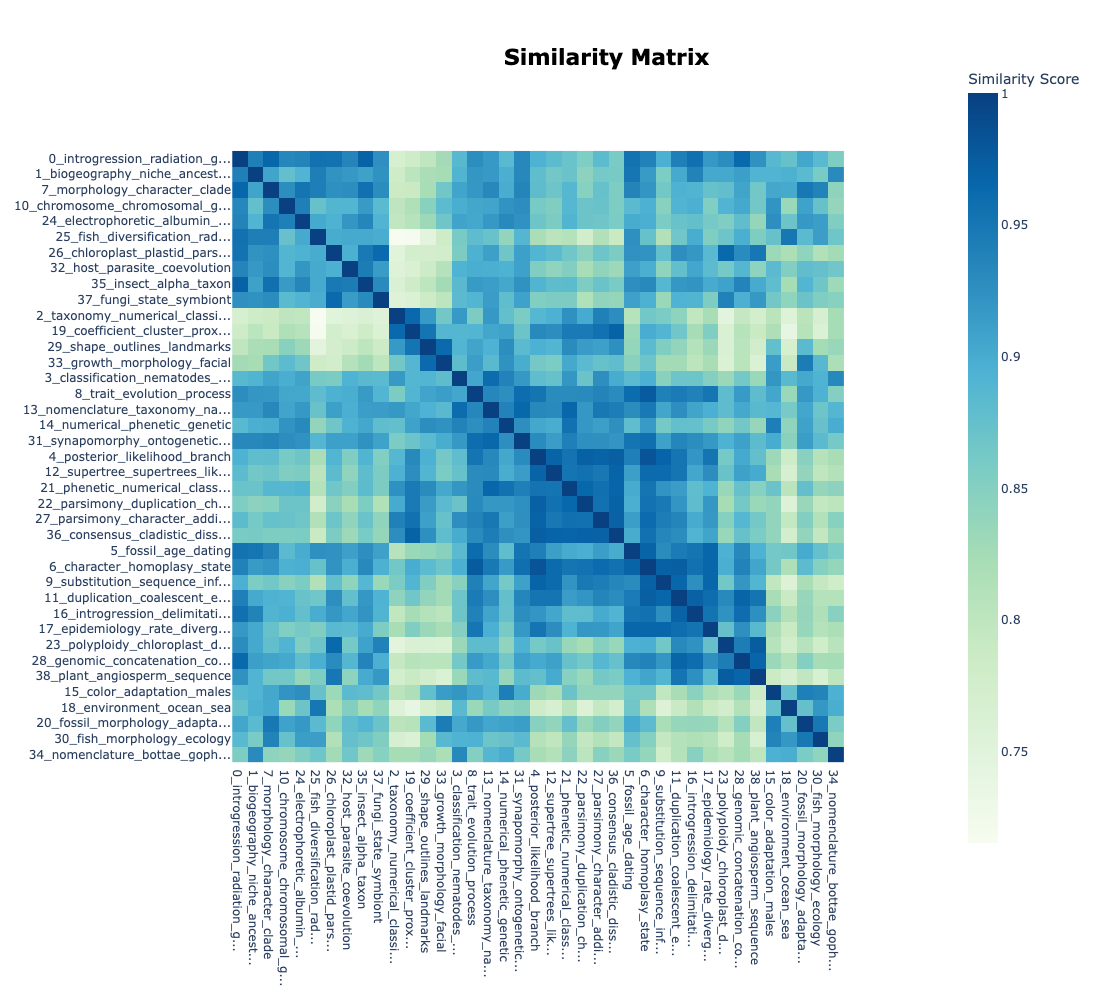

In [47]:
# show similarity matrix among topics
fig = topic_model.visualize_heatmap(n_clusters=6, height=1000, width=1000)
# fig.write_image(plot_dir + "fig_extra_topic_heatmap.pdf", format="pdf", scale=2, height=1000, width=1000) # pdf has terrible resolution
fig.write_image(plot_dir + "fig_extra_topic_heatmap.png", format="png", scale=1, height=1000, width=1000)    # png looks better
fig

In [ ]:
# Useful to inspect words in a specific article (text) contribute to different topic assignments
paper_idx = 100
print(f'Inspecting article with index {paper_idx}:')
print('Article text:')
print(texts[paper_idx])

# get topic probabilities
fig1 = topic_model.visualize_distribution(topic_distr[paper_idx])
print('Topic probabilities:')
fig1.show()

# get topic probs per token
fig2 = topic_model.visualize_approximate_distribution(texts[paper_idx], topic_token_distr[paper_idx])
print('Topic probabilities per token:')
fig2

## Article types (processing & visualization)

In [ ]:
# gather article statistics vs year
tmp_df = {
    'pov_len':  df_orig[ df_orig['Document.Type.Curated']=='Point Of View'   ].groupby('Volume')['PageLength'].mean(),
    'art_len':  df_orig[ df_orig['Document.Type.Curated']=='Research Article'].groupby('Volume')['PageLength'].mean(),
    'book_len': df_orig[ df_orig['Document.Type.Curated']=='Book Review'     ].groupby('Volume')['PageLength'].mean(),
    'pov_num':  df_orig[ df_orig['Document.Type.Curated']=='Point Of View'   ].groupby('Volume')['PageLength'].count(),
    'art_num':  df_orig[ df_orig['Document.Type.Curated']=='Research Article'].groupby('Volume')['PageLength'].count(),
    'book_num': df_orig[ df_orig['Document.Type.Curated']=='Book Review'     ].groupby('Volume')['PageLength'].count()
}

# get moving averages of counts/mean-lengths
y_df = {}
volumes = list(range(1,76))
for k,v in tmp_df.items():
    y = np.zeros( len(volumes) )
    x_tmp = [ int(z-1) for z in v.axes[0].tolist()]
    y_tmp = v.tolist()
    # set moving average to 1-year (no effect) but leaving code in place
    y[x_tmp] = moving_average( y_tmp, 1)
    y_df[k] = y

# 1952 to 2024 (vols 1-73)
max_vol = 73     # ignore vol74 since 2025 is not over yet
volumes = volumes[:max_vol]
for k,v in y_df.items():
    y_df[k] = v[:max_vol]

# RECHECK THIS, MJL 250805

# adjust to years
years = 2025 - np.array(volumes[:max_vol]) - 0    ## gives 1952 - 2024 (correct, rerun for revisions)
years = years[::-1]

In [ ]:
# FIGURE 3: NUMBER/LENGTH OF ARTICLE VS YEAR

fig, ax = plt.subplots( nrows=1, ncols=2)
fig.set_size_inches(10, 5)

colors = {
    'art':  '#a044b2',
    'pov':  '#2a9d6f',
    'book': '#e1a95f',
}
lw = 1.25

# number of articles
ax[0].plot(years, y_df['art_num'], c=colors['art'], label='Research Article', lw=lw)
ax[0].plot(years, y_df['pov_num'], c=colors['pov'], label='Point of View', lw=lw)
ax[0].plot(years, y_df['book_num'], c=colors['book'], label='Book Review', lw=lw)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Num. articles')
ax[0].legend()

# number of articles
ax[1].plot(years, y_df['art_len'], c=colors['art'], label='Research Article', lw=lw)
ax[1].plot(years, y_df['pov_len'], c=colors['pov'], label='Point of View', lw=lw)
ax[1].plot(years, y_df['book_len'], c=colors['book'], label='Book Review', lw=lw)
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Mean article length')
ax[1].legend()

# save
plt.savefig(plot_dir + 'fig3_article_types_thru_time.pdf')